In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
# Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını tanımla
dataset_path = "/content/drive/MyDrive/reduced_dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Veri seti hakkında bilgi topla
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}")
print(f"Sınıflar: {class_names}")

# Görüntü boyutlarını tanımla
img_height, img_width = 224, 224
batch_size = 512

# Veri artırma ve normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Veri yükleyicileri oluştur
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Mounted at /content/drive
Sınıf sayısı: 3
Sınıflar: ['glass', 'paper', 'plastic']
Found 3600 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 675 images belonging to 3 classes.


In [ ]:
# Geri çağırmalar (callbacks) oluştur
def create_callbacks(model_name):
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name}_best.h5"
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max',
        save_weights_only=False
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]


In [ ]:
# Model oluşturma ve eğitim fonksiyonu
def create_and_train_model(base_model_fn, model_name, epochs=100):
    print(f"\n{'='*50}")
    print(f"Eğitim başlıyor: {model_name}")
    print(f"{'='*50}\n")

    # Temel modeli yükle
    base_model = base_model_fn(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    # Temel modeli dondur
    base_model.trainable = False

    # Yeni sınıflandırıcı katmanları ekle
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Model oluştur
    model = Model(inputs=base_model.input, outputs=predictions)

    # Derleme
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Model özetini göster
    print(f"{model_name} özeti:")
    #model.summary()

    # Modeli eğit
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=create_callbacks(model_name)
    )

    # İnce ayar (Fine-tuning) - en üst katmanları eğitilebilir yap
    print(f"\n{model_name} için ince ayar yapılıyor...")

    # Son blok/katmanları eğitilebilir yap
    if model_name == "DenseNet121":
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    elif model_name == "VGG16":
        for layer in base_model.layers[-4:]:
            layer.trainable = True

    # Daha düşük öğrenme oranıyla yeniden derle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # İnce ayar eğitimi
    fine_tune_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=create_callbacks(f"{model_name}_finetuned")
    )

    # Tüm eğitim geçmişini birleştir
    combined_history = {}
    for k in history.history.keys():
        combined_history[k] = history.history[k] + fine_tune_history.history[k]

    # Test veri seti üzerinde değerlendir
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{model_name} Test accuracy: {test_acc:.4f}")

    # Modeli kaydet
    model.save(f"/content/drive/MyDrive/models/{model_name}_finall.h5")

    # Eğitim ve doğrulama grafiklerini çiz
    plot_training_history(combined_history, model_name)
    evaluate_model(model, model_name)

    return model, combined_history

In [ ]:
#Eğitim grafiklerini çizme fonksiyonu
def plot_training_history(history, model_name):
    # Doğruluk (accuracy) grafiği
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Kayıp (loss) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/models/{model_name}_training_history.png")
    plt.show()

# Kaydetme dizini oluştur
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)



In [ ]:
# Confusion matrix ve classification report çizdirme fonksiyonu
def evaluate_model(model, model_name):
    # Test verileri üzerinden tahmin yap
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Görselleştir
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/models/{model_name}_confusion_matrix.png")
    plt.show()


Eğitim başlıyor: DenseNet121

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 özeti:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.5015 - loss: 1.1592 
Epoch 1: val_accuracy improved from -inf to 0.84889, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 394s 49s/step - accuracy: 0.5133 - loss: 1.1313 - val_accuracy: 0.8489 - val_loss: 0.3733 - learning_rate: 0.0010
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7969 - loss: 0.5212

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.84889 to 0.87556, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.7969 - loss: 0.5212 - val_accuracy: 0.8756 - val_loss: 0.3255 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8226 - loss: 0.4276
Epoch 3: val_accuracy improved from 0.87556 to 0.90222, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8240 - loss: 0.4247 - val_accuracy: 0.9022 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 4/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6250 - loss: 0.9487
Epoch 4: val_accuracy did not improve from 0.90222
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6250 - loss: 0.9487 - val_accuracy: 0.8933 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8604 - loss: 0.3449 
Epoch 5: val_accuracy improved from 0.90222 to 0.90667, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8610 - loss: 0.3445 - val_accuracy: 0.9067 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 6/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.8574 - loss: 0.3484
Epoch 6: val_accuracy improved from 0.90667 to 0.91111, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8574 - loss: 0.3484 - val_accuracy: 0.9111 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8787 - loss: 0.3185
Epoch 7: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8787 - loss: 0.3175 - val_accuracy: 0.8978 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 8/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9375 - loss: 0.1229
Epoch 8: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9375 - loss: 0.1229 - val_accuracy: 0.9067 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8807 - loss: 0.2914
Epoch 9: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8809 - loss: 0.2913 - val_accuracy: 0.9022 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 10/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/st

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8928 - loss: 0.2590 - val_accuracy: 0.9200 - val_loss: 0.2231 - learning_rate: 0.0010
Epoch 12/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9219 - loss: 0.2210
Epoch 12: val_accuracy did not improve from 0.92000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9219 - loss: 0.2210 - val_accuracy: 0.9156 - val_loss: 0.2220 - learning_rate: 0.0010
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9168 - loss: 0.2243
Epoch 13: val_accuracy improved from 0.92000 to 0.92444, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9161 - loss: 0.2266 - val_accuracy: 0.9244 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 14/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9102 - loss: 0.2394
Epoch 14: val_accuracy did not improve from 0.92444
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9102 - loss: 0.2394 - val_accuracy: 0.9156 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9123 - loss: 0.2145
Epoch 15: val_accuracy did not improve from 0.92444
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9119 - loss: 0.2153 - val_accuracy: 0.9200 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 16/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9043 - loss: 0.2499
Epoch 16: val_accuracy improved from 0.92444 to 0.92889, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9043 - loss: 0.2499 - val_accuracy: 0.9289 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 17/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9160 - loss: 0.2098 
Epoch 17: val_accuracy improved from 0.92889 to 0.93333, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9163 - loss: 0.2089 - val_accuracy: 0.9333 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 18/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.9180 - loss: 0.2044
Epoch 18: val_accuracy did not improve from 0.93333

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9180 - loss: 0.2044 - val_accuracy: 0.9067 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9250 - loss: 0.2154
Epoch 19: val_accuracy did not improve from 0.93333
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9247 - loss: 0.2156 - val_accuracy: 0.9333 - val_loss: 0.2223 - learning_rate: 2.0000e-04
Epoch 20/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9141 - loss: 0.2224
Epoch 20: val_accuracy improved from 0.93333 to 0.93778, saving model to /content/drive/MyDrive/models/DenseNet121_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.9141 - loss: 0.2224 - val_accuracy: 0.9378 - val_loss: 0.2164 - learning_rate: 2.0000e-04
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9278 - loss: 0.1910
Epoch 21: val_accuracy did not improve from 0.93778
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9273 - loss: 0.1916 - val_accuracy: 0.9156 - val_loss: 0.2101 - learning_rate: 2.0000e-04
Epoch 22/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8945 - loss: 0.2289
Epoch 22: val_accuracy did not improve from 0.93778
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8945 - loss: 0.2289 - val_accuracy: 0.9156 - val_loss: 0.2097 - learning_rate: 2.0000e-04
Epoch 23/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8963 - loss: 0.2399
Epoch 23: val_accuracy did not improve from 0.93778
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8995 - loss: 0.2339 - val_accuracy: 0.9289 - val_loss: 0.2056 - learning_rate: 2.0000e-04
Epoch 24/100
1/7 ━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9024 - loss: 0.2572 - val_accuracy: 0.8889 - val_loss: 0.2743 - learning_rate: 1.0000e-04
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9336 - loss: 0.1966
Epoch 2: val_accuracy did not improve from 0.88889
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9336 - loss: 0.1966 - val_accuracy: 0.8889 - val_loss: 0.2780 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9221 - loss: 0.2043
Epoch 3: val_accuracy improved from 0.88889 to 0.90667, saving model to /content/drive/MyDrive/models/DenseNet121_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.9221 - loss: 0.2046 - val_accuracy: 0.9067 - val_loss: 0.2402 - learning_rate: 1.0000e-04
Epoch 4/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9453 - loss: 0.1628
Epoch 4: val_accuracy did not improve from 0.90667
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9453 - loss: 0.1628 - val_accuracy: 0.9067 - val_loss: 0.2333 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9310 - loss: 0.1851
Epoch 5: val_accuracy improved from 0.90667 to 0.91111, saving model to /content/drive/MyDrive/models/DenseNet121_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.9307 - loss: 0.1852 - val_accuracy: 0.9111 - val_loss: 0.2060 - learning_rate: 1.0000e-04
Epoch 6/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9180 - loss: 0.2088
Epoch 6: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.9180 - loss: 0.2088 - val_accuracy: 0.9111 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9246 - loss: 0.1893
Epoch 7: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9248 - loss: 0.1889 - val_accuracy: 0.9111 - val_loss: 0.2188 - learning_rate: 1.0000e-04
Epoch 8/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.9375 - loss: 0.1663
Epoch 8: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9375 - loss: 0.1663 - val_accuracy: 0.9111 - val_loss: 0.2178 - learning_rate: 1.0000e-04
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━


DenseNet121 Test accuracy: 0.9274


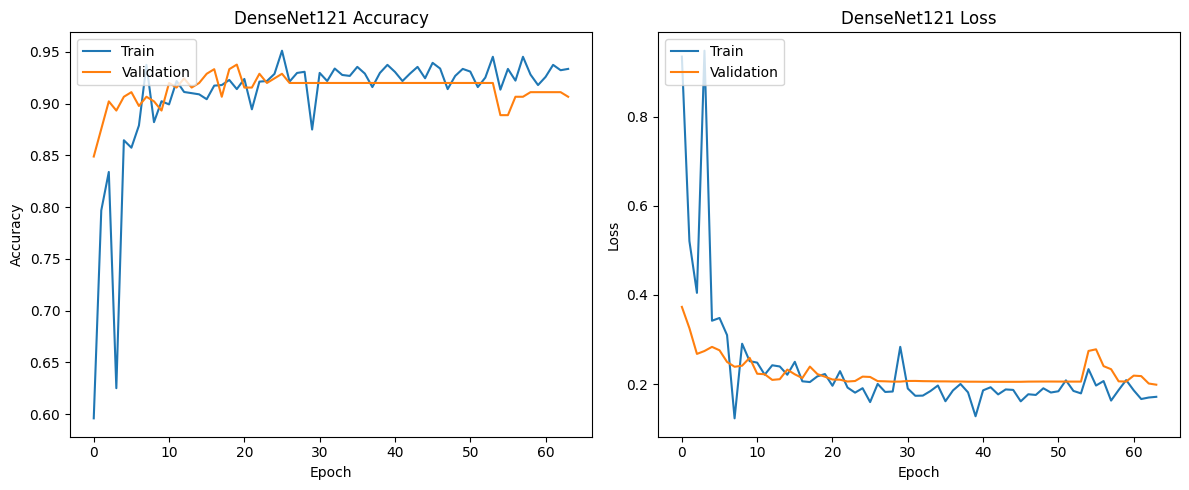

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step

DenseNet121 - Classification Report:
              precision    recall  f1-score   support

       glass       0.95      0.85      0.90       225
       paper       0.97      0.98      0.97       225
     plastic       0.87      0.96      0.91       225

    accuracy                           0.93       675
   macro avg       0.93      0.93      0.93       675
weighted avg       0.93      0.93      0.93       675



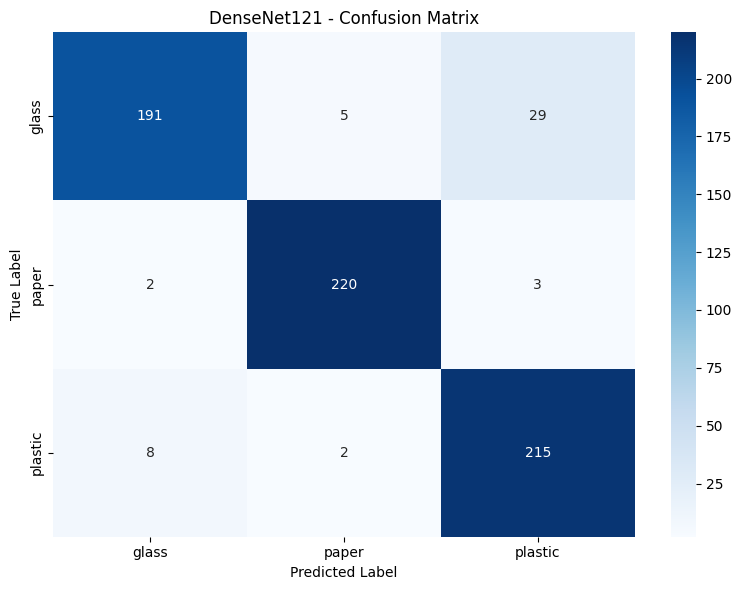


Eğitim başlıyor: VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 özeti:
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3657 - loss: 1.1706
Epoch 1: val_accuracy improved from -inf to 0.63111, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.3710 - loss: 1.1634 - val_accuracy: 0.6311 - val_loss: 0.8870 - learning_rate: 0.0010
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.5293 - loss: 1.0002

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.63111 to 0.66222, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.5293 - loss: 1.0002 - val_accuracy: 0.6622 - val_loss: 0.8566 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5506 - loss: 0.9341
Epoch 3: val_accuracy improved from 0.66222 to 0.77333, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.5532 - loss: 0.9298 - val_accuracy: 0.7733 - val_loss: 0.7161 - learning_rate: 0.0010
Epoch 4/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6074 - loss: 0.8707
Epoch 4: val_accuracy did not improve from 0.77333
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.6074 - loss: 0.8707 - val_accuracy: 0.7644 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6555 - loss: 0.7887
Epoch 5: val_accuracy did not improve from 0.77333
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.6563 - loss: 0.7869 - val_accuracy: 0.7600 - val_loss: 0.6221 - learning_rate: 0.0010
Epoch 6/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4375 - loss: 0.7517
Epoch 6: val_accuracy did not improve from 0.77333
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4375 - loss: 0.7517 - val_accuracy: 0.7644 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/ste

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7455 - loss: 0.6122 - val_accuracy: 0.8044 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 12/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.7598 - loss: 0.6133
Epoch 12: val_accuracy did not improve from 0.80444
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.7598 - loss: 0.6133 - val_accuracy: 0.7911 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7474 - loss: 0.5894
Epoch 13: val_accuracy did not improve from 0.80444
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7487 - loss: 0.5874 - val_accuracy: 0.7733 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 14/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.7695 - loss: 0.5410
Epoch 14: val_accuracy did not improve from 0.80444
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.7695 - loss: 0.5410 - val_accuracy: 0.7778 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7947 - loss: 0.5195 - val_accuracy: 0.8222 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 18/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8105 - loss: 0.4875
Epoch 18: val_accuracy improved from 0.82222 to 0.82667, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8105 - loss: 0.4875 - val_accuracy: 0.8267 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 19/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8249 - loss: 0.4779 
Epoch 19: val_accuracy improved from 0.82667 to 0.84000, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8246 - loss: 0.4763 - val_accuracy: 0.8400 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 20/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.7852 - loss: 0.5206
Epoch 20: val_accuracy did not improve from 0.84000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.7852 - loss: 0.5206 - val_accuracy: 0.8400 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8117 - loss: 0.4781
Epoch 21: val_accuracy did not improve from 0.84000
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8120 - loss: 0.4772 - val_accuracy: 0.8267 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 22/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8340 - loss: 0.4400
Epoch 22: val_accuracy did not improve from 0.84000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.8340 - loss: 0.4400 - val_accuracy: 0.8356 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 23/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8266 - loss: 0.4491 - val_accuracy: 0.8444 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 24/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8086 - loss: 0.4817
Epoch 24: val_accuracy improved from 0.84444 to 0.84889, saving model to /content/drive/MyDrive/models/VGG16_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8086 - loss: 0.4817 - val_accuracy: 0.8489 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8373 - loss: 0.4402
Epoch 25: val_accuracy did not improve from 0.84889
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8366 - loss: 0.4398 - val_accuracy: 0.8400 - val_loss: 0.4256 - learning_rate: 0.0010
Epoch 26/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8086 - loss: 0.4881
Epoch 26: val_accuracy did not improve from 0.84889
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8086 - loss: 0.4881 - val_accuracy: 0.8400 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 27/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8174 - loss: 0.4350
Epoch 27: val_accuracy did not improve from 0.84889
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8184 - loss: 0.4349 - val_accuracy: 0.8311 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 28/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8233 - loss: 0.4023 - val_accuracy: 0.8533 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 44/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8340 - loss: 0.4143
Epoch 44: val_accuracy did not improve from 0.85333
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8340 - loss: 0.4143 - val_accuracy: 0.8400 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 45/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8366 - loss: 0.3977
Epoch 45: val_accuracy did not improve from 0.85333
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8373 - loss: 0.3966 - val_accuracy: 0.8311 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 46/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8594 - loss: 0.3466
Epoch 46: val_accuracy did not improve from 0.85333
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8594 - loss: 0.3466 - val_accuracy: 0.8133 - val_loss: 0.3914 - learning_rate: 0.0010
Epoch 47/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.8700 - loss: 0.3436 - val_accuracy: 0.8578 - val_loss: 0.3538 - learning_rate: 2.0000e-04
Epoch 74/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8125 - loss: 0.5228
Epoch 74: val_accuracy did not improve from 0.85778
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8125 - loss: 0.5228 - val_accuracy: 0.8489 - val_loss: 0.3553 - learning_rate: 2.0000e-04
Epoch 75/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8729 - loss: 0.3300
Epoch 75: val_accuracy did not improve from 0.85778
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8727 - loss: 0.3304 - val_accuracy: 0.8444 - val_loss: 0.3539 - learning_rate: 2.0000e-04
Epoch 76/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8750 - loss: 0.4146
Epoch 76: val_accuracy did not improve from 0.85778

Epoch 76: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8750 - loss: 0.4146 - val_accuracy

7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.7598 - loss: 0.7423 - val_accuracy: 0.7244 - val_loss: 0.5877 - learning_rate: 1.0000e-04
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7617 - loss: 0.5563
Epoch 2: val_accuracy improved from 0.72444 to 0.75556, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.7617 - loss: 0.5563 - val_accuracy: 0.7556 - val_loss: 0.5023 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8007 - loss: 0.4757
Epoch 3: val_accuracy improved from 0.75556 to 0.82667, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8034 - loss: 0.4709 - val_accuracy: 0.8267 - val_loss: 0.3925 - learning_rate: 1.0000e-04
Epoch 4/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8867 - loss: 0.2984
Epoch 4: val_accuracy did not improve from 0.82667
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8867 - loss: 0.2984 - val_accuracy: 0.8222 - val_loss: 0.4059 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8748 - loss: 0.3290
Epoch 5: val_accuracy improved from 0.82667 to 0.83111, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8749 - loss: 0.3263 - val_accuracy: 0.8311 - val_loss: 0.4283 - learning_rate: 1.0000e-04
Epoch 6/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.8965 - loss: 0.2444
Epoch 6: val_accuracy did not improve from 0.83111
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.8965 - loss: 0.2444 - val_accuracy: 0.8311 - val_loss: 0.4187 - learning_rate: 1.0000e-04
Epoch 7/10
6/7 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8986 - loss: 0.2679 
Epoch 7: val_accuracy improved from 0.83111 to 0.85778, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8996 - loss: 0.2665 - val_accuracy: 0.8578 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 8/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.8789 - loss: 0.2875
Epoch 8: val_accuracy improved from 0.85778 to 0.87556, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8789 - loss: 0.2875 - val_accuracy: 0.8756 - val_loss: 0.3081 - learning_rate: 1.0000e-04
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9146 - loss: 0.2273
Epoch 9: val_accuracy improved from 0.87556 to 0.89778, saving model to /content/drive/MyDrive/models/VGG16_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9151 - loss: 0.2258 - val_accuracy: 0.8978 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 10/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9199 - loss: 0.2000
Epoch 10: val_accuracy did not improve from 0.89778
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9199 - loss: 0.2000 - val_accuracy: 0.8889 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 10s/step - accuracy: 0.9085 - loss: 0.2382



VGG16 Test accuracy: 0.9096


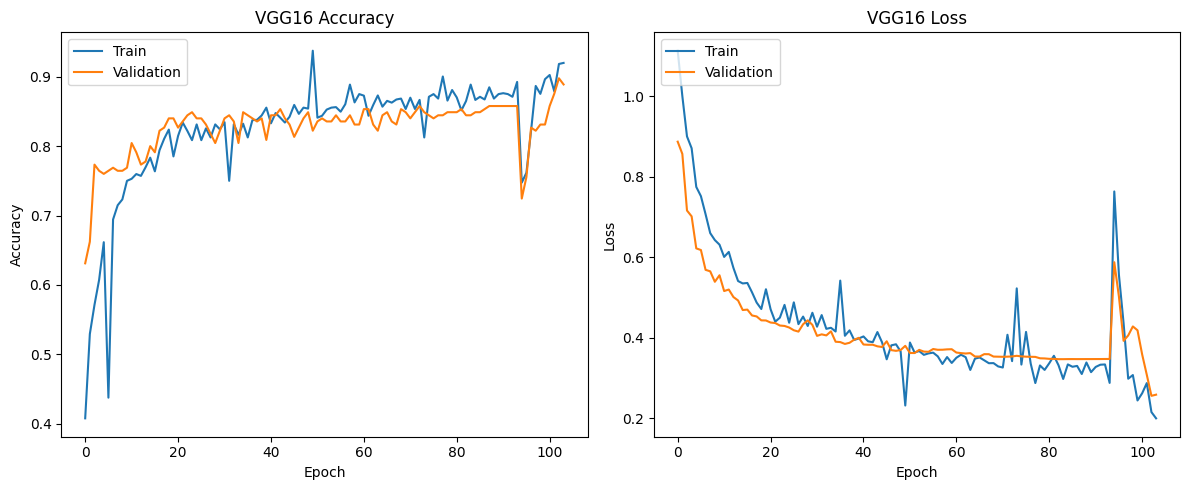

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step

VGG16 - Classification Report:
              precision    recall  f1-score   support

       glass       0.92      0.86      0.89       225
       paper       0.94      0.98      0.96       225
     plastic       0.87      0.89      0.88       225

    accuracy                           0.91       675
   macro avg       0.91      0.91      0.91       675
weighted avg       0.91      0.91      0.91       675



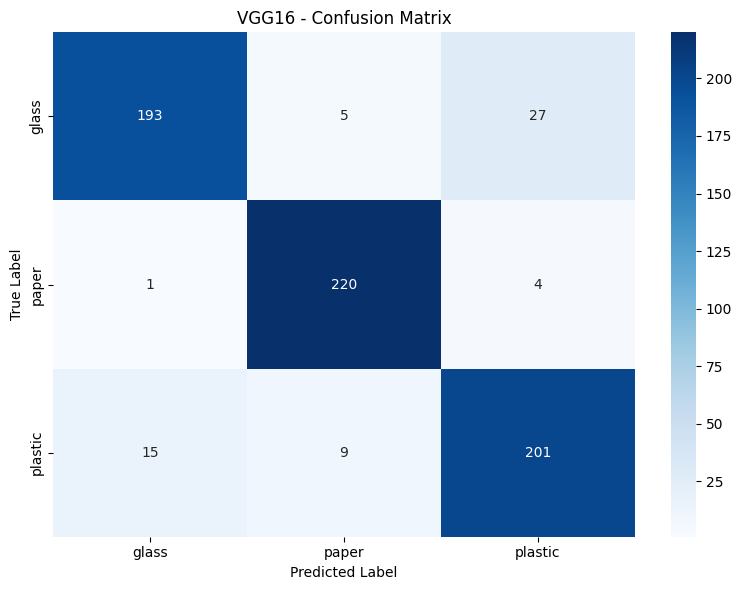

In [ ]:
# Her modeli eğit
# 1. DenseNet121
densenet_model, densenet_history = create_and_train_model(DenseNet121, "DenseNet121")

# 2. VGG16
vgg_model, vgg_history = create_and_train_model(VGG16, "VGG16")


In [ ]:
# Tüm modellerin performansını karşılaştır
def compare_models():
    models = [
        ("DenseNet121", densenet_history),
        ("VGG16", vgg_history)
    ]

    plt.figure(figsize=(12, 10))

    # Doğruluk (accuracy) karşılaştırması
    plt.subplot(2, 1, 1)
    for name, history in models:
        plt.plot(history['val_accuracy'])

    plt.title('Model Karşılaştırması - Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([name for name, _ in models], loc='lower right')

    # Kayıp (loss) karşılaştırması
    plt.subplot(2, 1, 2)
    for name, history in models:
        plt.plot(history['val_loss'])

    plt.title('Model Karşılaştırması - Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([name for name, _ in models], loc='upper right')

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/models/model_comparison.png")
    plt.show()


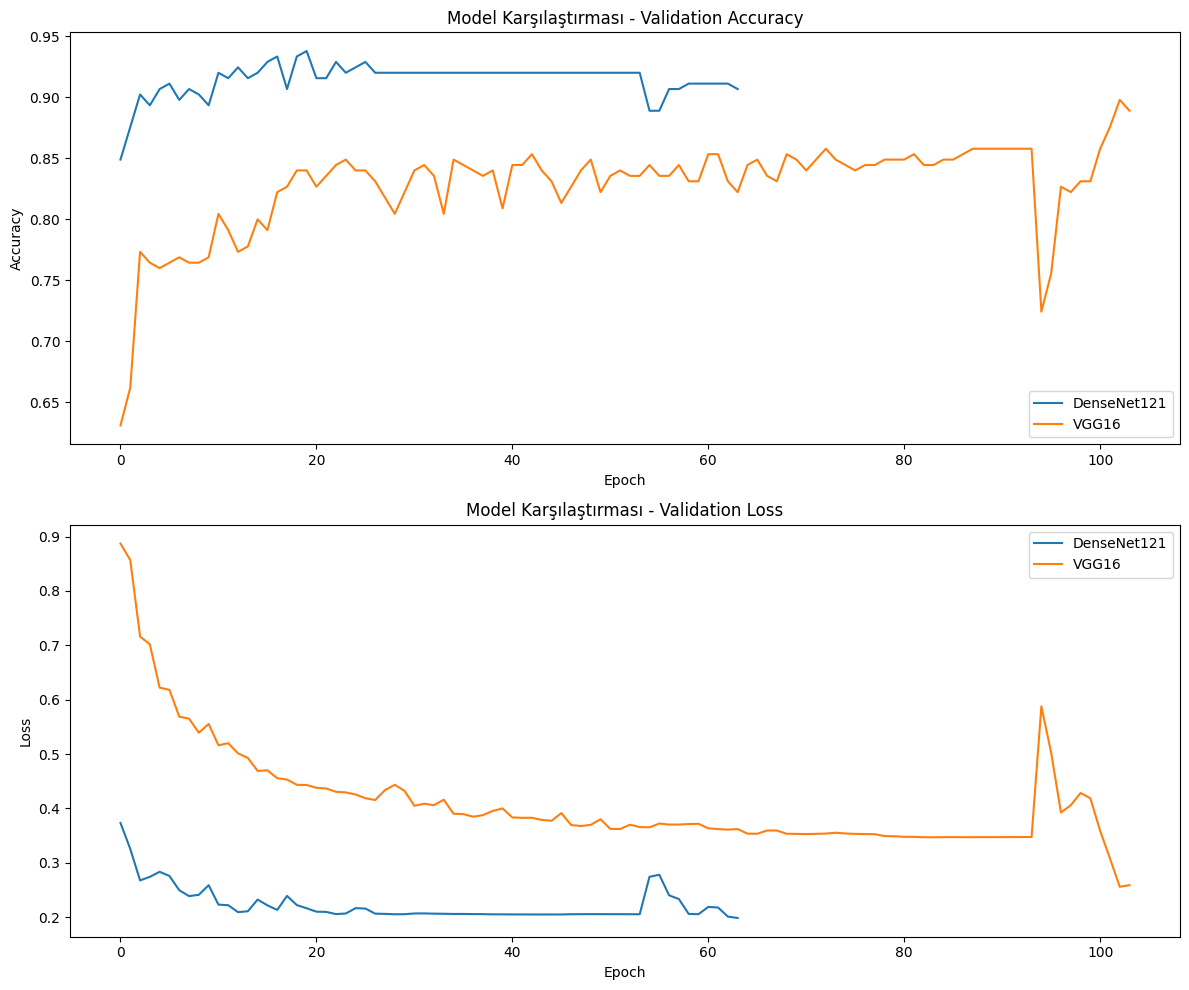

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.9236 - loss: 0.2059
DenseNet121 Test Accuracy: 0.9274
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9085 - loss: 0.2382
VGG16 Test Accuracy: 0.9096

En iyi performans gösteren model: DenseNet121, Test Accuracy: 0.9274


In [ ]:
# Modelleri karşılaştır
compare_models()

# En iyi performans gösteren modeli belirle
def find_best_model():
    models = [
        ("DenseNet121", densenet_model),
        ("VGG16", vgg_model)
    ]

    best_acc = 0
    best_model_name = ""

    for name, model in models:
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"{name} Test Accuracy: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_name = name

    print(f"\nEn iyi performans gösteren model: {best_model_name}, Test Accuracy: {best_acc:.4f}")

# En iyi modeli bul
find_best_model()